# Clustering and PCA Assignment

## Country Cluster Identification

### Problem Statement


HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

 

And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.  The datasets containing those socio-economic factors and the corresponding data dictionary are provided below.

### Import the necessary Libararies and Classes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

# Set the no of columns to be displayed to 500
pd.set_option('display.max_columns', 500)

# Set the no of rows to be displayed to 200
pd.set_option('display.max_rows', 200)

#set scientific noations 9.8e+11 to 9888777777.1245
pd.options.display.float_format = '{:.4f}'.format



# Import libararies, specific to Machine Learning/Clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Import libararies for Hirarchical Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


# Import libararies for PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA



In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Read And Visualise the data

In [3]:
####################### Define Global Variables ##################################

# Assign the path of the local dir to a variable. 
#This path must be updated, if the notebook is being executed on a different machine.

Local_Dir = r"C:\DS_Learning\Data_Science_IITB\Machine_Learning\PCA\Clustering_And_PCA_Assignment"


# Store the name of the file in a variable. The file contanins the data about the countries and their socio-economic factors.
# The variable must be updated, if a different version of file being used


lfile = r"\Country-data.csv"
Country_Dataset = str(Local_Dir + lfile)

In [4]:
#Read the country dataset and load it into a Dataframe df
df = pd.read_csv(Country_Dataset) 

In [5]:
# Get the basic information about the Dataset
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


In [6]:
# Get the no of rows and columns
print('\t Country Dataset has {} rows and {} columns ..'.format(df.shape[0],df.shape[1]))

	 Country Dataset has 167 rows and 10 columns ..


In [7]:
# Print the datatype of each column of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


## Check For Missing Values
It seems, all the columns are populated, there are no NULL values in any of the columns.

Let's verify once

In [8]:
Null_Pcent = 100*(round(df.isnull().sum()/len(df.index),2))
print(Null_Pcent)

country      0.0000
child_mort   0.0000
exports      0.0000
health       0.0000
imports      0.0000
income       0.0000
inflation    0.0000
life_expec   0.0000
total_fer    0.0000
gdpp         0.0000
dtype: float64


The above output confirms that all the columns are populated and there is no need to perform any missing 
values treatment/imputation

# Data Analysis and Visualisation

## Check For Outliers

In [9]:
# Get all the numeric columns into a list "cols"
cols = df.select_dtypes(exclude = 'object').columns

In [10]:
# Define a function to plot the data, to avoide repition of code
def Check_Outliers():
    l_row = len(cols)
    l_col = 3
    l_pos = 1
    fig = plt.figure(figsize=(20,30))
    for col in cols:
        fig.add_subplot(l_row, l_col, l_pos)
        plt.title(col, fontsize = 20)
        sns.boxplot(data = df, y = col)
        #plt.yscale('log')
        l_pos = l_pos + 1
    plt.show()

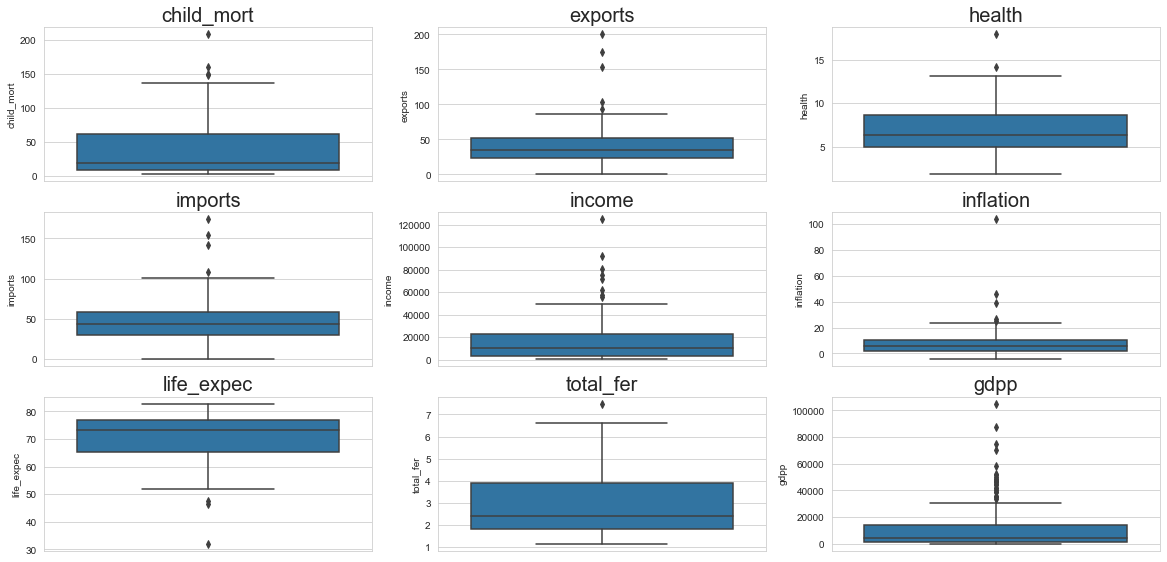

In [11]:
Check_Outliers()

## Observations

We can clearly see that there are outliers present in all the columns especially `gdpp`, `child_mort`, `inflation`,`income` etc of the dataset.
Since, we need to group the countries based on these columns/factors, and treating outliers is also one of the major steps of clustering, hence, it would be better to remove the outliers.

Let's check the data statistically

In [12]:
# describe the data
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,41.1090,6.8157,46.8902,17144.6886,7.7818,70.5557,2.9480,12964.1557
std,40.3289,27.4120,2.7468,24.2096,19278.0677,10.5707,8.8932,1.5138,18328.7048
min,2.6000,0.1090,1.8100,0.0659,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,23.8000,4.9200,30.2000,3355.0000,1.8100,65.3000,1.7950,1330.0000
50%,19.3000,35.0000,6.3200,43.3000,9960.0000,5.3900,73.1000,2.4100,4660.0000
75%,62.1000,51.3500,8.6000,58.7500,22800.0000,10.7500,76.8000,3.8800,14050.0000
max,208.0000,200.0000,17.9000,174.0000,125000.0000,104.0000,82.8000,7.4900,105000.0000


### Let's take a backup of the main DF before making any changes

In [13]:
# Copy the dataframe
df_orig = df.copy()

df_orig.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


### Treat The Outliers
 Since, we need to perform the analysis, based on the socio and economy factors, hence, it is not recommended to remove
 the countries, that are outliers. A good practice is to cap them to avoide any impact of outliers

In [14]:
for l_col in cols:
    Q1 = df[l_col].quantile(0.05)
    Q3 = df[l_col].quantile(0.95)
    IQR = Q3 - Q1
    df[l_col][df[l_col] <= Q1] = Q1
    df[l_col][df[l_col] >= Q3] = Q3

In [15]:
print(df.shape)
df.describe()

(167, 10)


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,36.8086,39.3108,6.7674,45.3643,15755.4910,7.0161,70.8301,2.9224,12003.7192
std,36.1938,19.8861,2.5293,18.3035,14770.3538,6.2714,8.0392,1.4383,15154.4439
min,3.4600,12.1200,2.7910,18.1300,1213.0000,0.1834,55.7800,1.3900,465.9000
25%,8.2500,23.8000,4.9200,30.2000,3355.0000,1.8100,65.3000,1.7950,1330.0000
50%,19.3000,35.0000,6.3200,43.3000,9960.0000,5.3900,73.1000,2.4100,4660.0000
75%,62.1000,51.3500,8.6000,58.7500,22800.0000,10.7500,76.8000,3.8800,14050.0000
max,116.0000,80.5700,11.5700,81.1400,48290.0000,20.8700,81.4000,5.8610,48610.0000


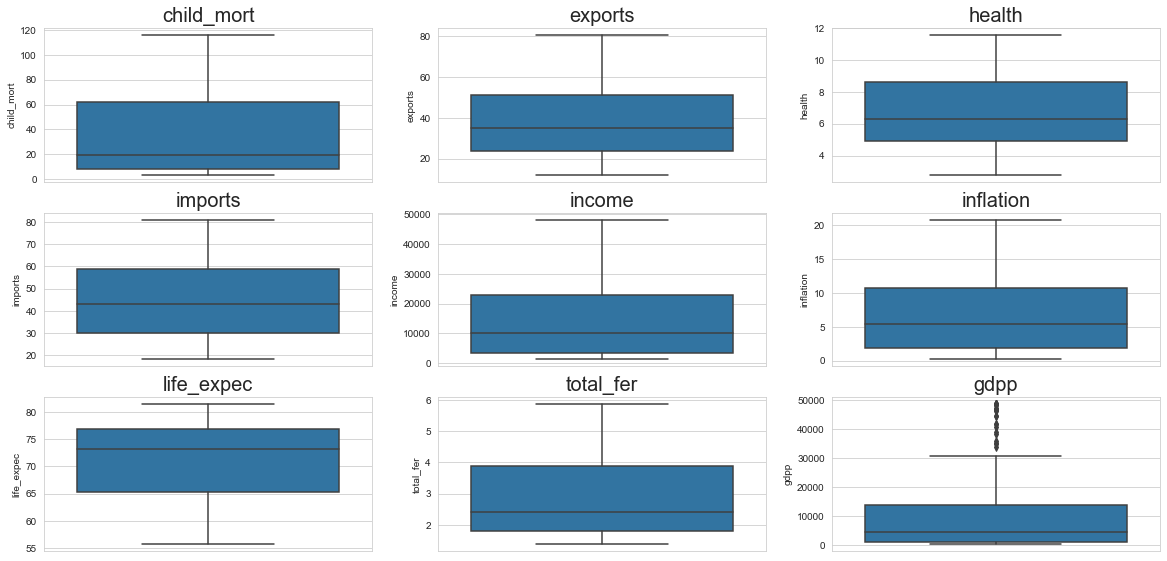

In [16]:
# Reverify the outliers
Check_Outliers()

It seems, Statistically removing outliers, does not make much difference in the overall dataset, as there are still outliers present in the dataset.

Let's leave this for now and go ahead for further analysis

## Univariate Analysis

As per the requirements, we need to identify the coutries that are in the direst need of aid.
Therefore, we can identify the top 10-15 countries based on the socio-economic factors

In [17]:
def plt_univariate():
    l_row = len(cols)
    l_col = 2
    l_pos = 1
    fig = plt.figure(figsize=(15,30))
    for col in cols:
        fig.add_subplot(l_row, l_col, l_pos)
        sns.barplot(x = 'country', y = col, data = df[['country', col]].sort_values(col, ascending = False).head(10))
        lstr = 'Top 10 Countries with high '
        l_title = lstr + col
        plt.xticks(rotation = '45')
        plt.title(l_title, fontsize = 20)
        l_pos = l_pos + 1
        
        fig.add_subplot(l_row, l_col, l_pos)
        sns.barplot(x = 'country', y = col, data = df[['country', col]].sort_values(col, ascending = True).head(10))
        lstr = 'Bottom 10 Countries with low '
        l_title = lstr + col
        plt.xticks(rotation = '45')
        plt.title(l_title, fontsize = 20)
        l_pos = l_pos + 1
    plt.tight_layout()
    plt.show()

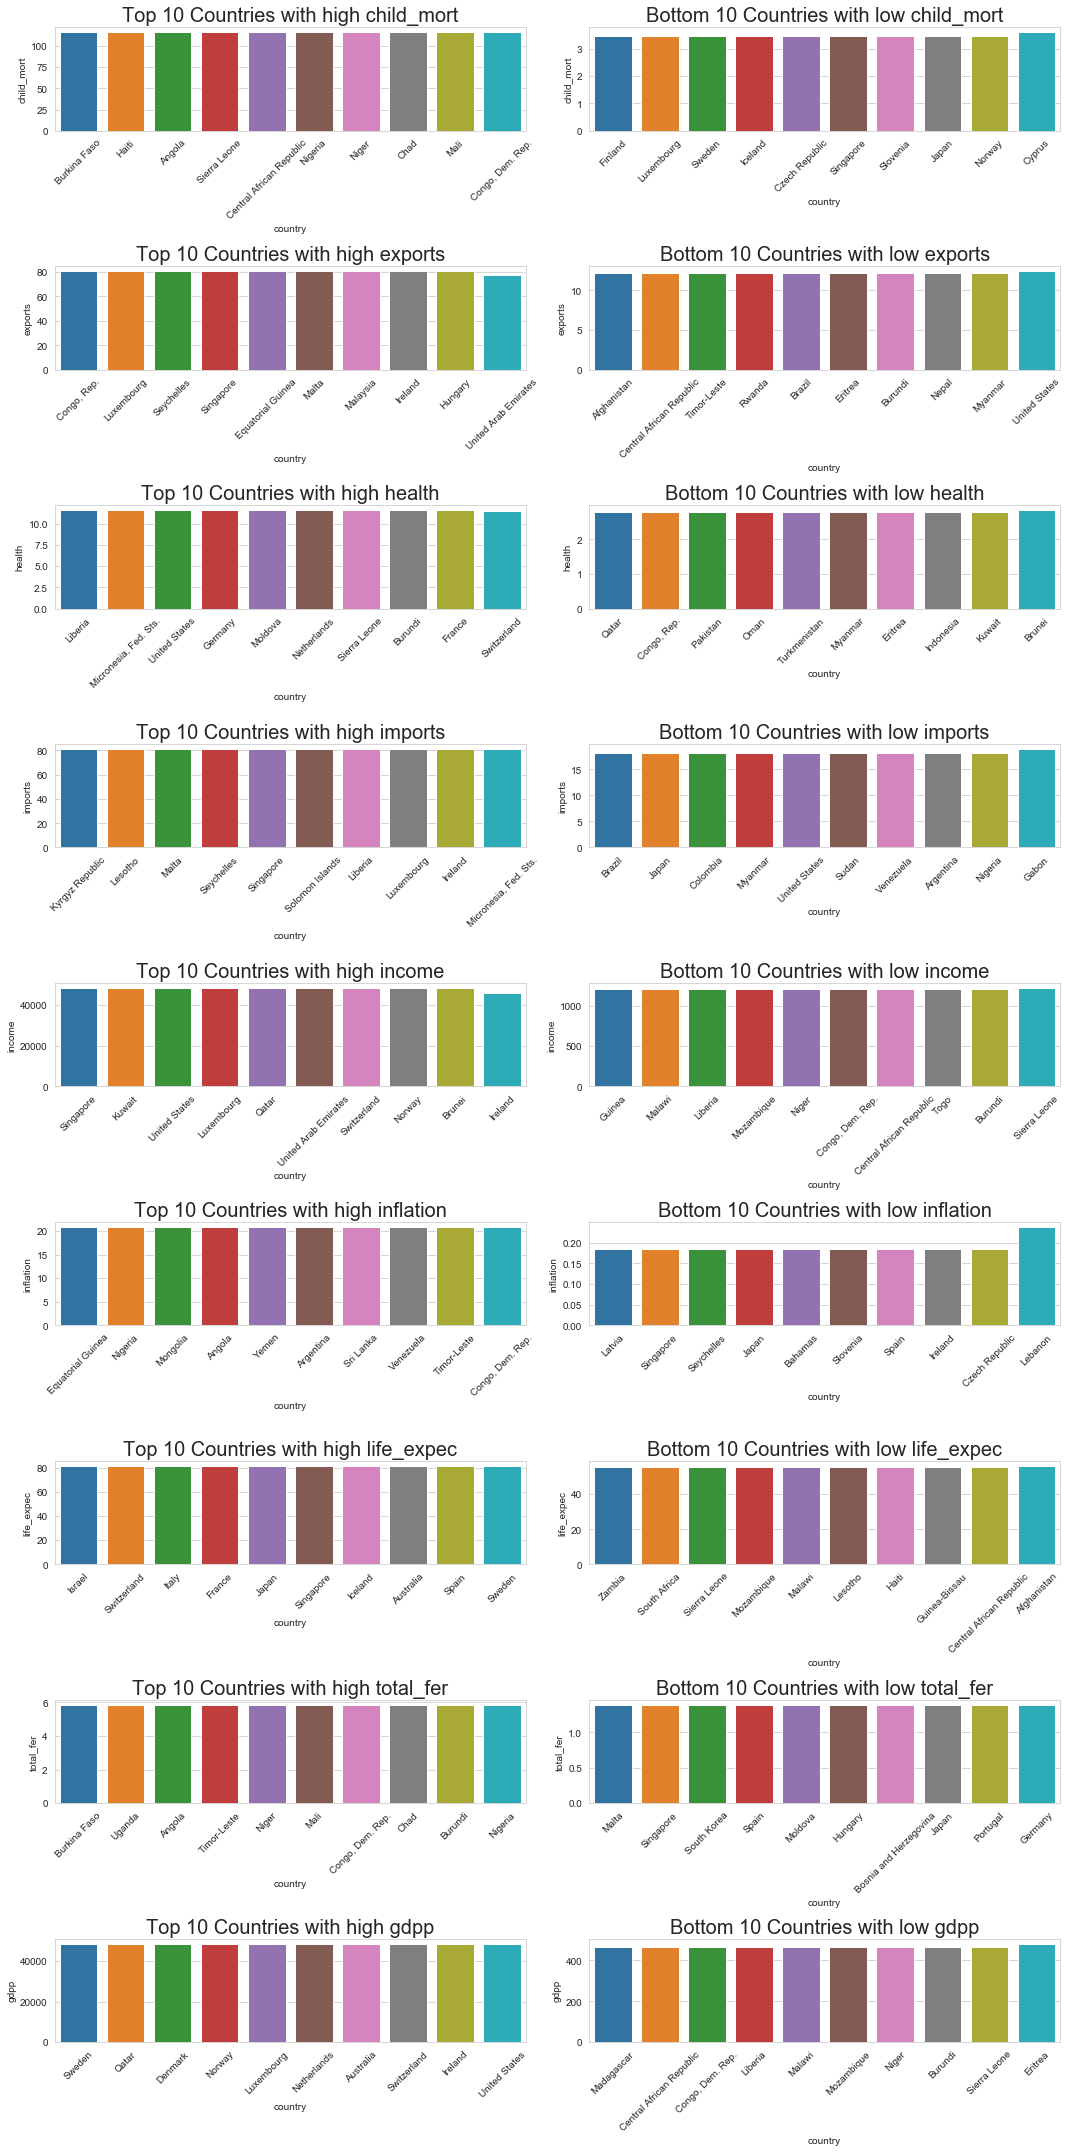

In [18]:
plt_univariate()

# Scale The Features

In [19]:
# Remove the variable "Country" from the dataframe
y = df.pop('country')

In [20]:
# Verify the dataframe
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2000,12.1200,7.5800,44.9000,1610.0000,9.4400,56.2000,5.8200,553.0000
1,16.6000,28.0000,6.5500,48.6000,9930.0000,4.4900,76.3000,1.6500,4090.0000
2,27.3000,38.4000,4.1700,31.4000,12900.0000,16.1000,76.5000,2.8900,4460.0000
3,116.0000,62.3000,2.8500,42.9000,5900.0000,20.8700,60.1000,5.8610,3530.0000
4,10.3000,45.5000,6.0300,58.9000,19100.0000,1.4400,76.8000,2.1300,12200.0000


In [21]:
# Create an instance of the StandardScaler() class
scaler = StandardScaler()

In [22]:
# perforom the scaling on the required variables
scaled_df = scaler.fit_transform(df)

In [23]:
# Verify the shape of scaled DF
scaled_df.shape

(167, 9)

## Perform PCA on the dataset

In [24]:
# Create an instance of the PCA
pca = PCA(svd_solver='randomized',random_state = 42)

# Perform PCA on the dataset
scaled_df_pca = pca.fit(scaled_df)

In [25]:
# Check the components from PCA
scaled_df_pca.components_

array([[-0.42162279,  0.23215649,  0.1813805 ,  0.09452367,  0.41088706,
        -0.22517641,  0.43188141, -0.40669251,  0.39376521],
       [-0.032585  , -0.59983764,  0.19168628, -0.72998099,  0.11098633,
         0.07988177,  0.12988256, -0.00878147,  0.18404209],
       [-0.0942617 ,  0.2952823 , -0.6464977 , -0.28358913,  0.19801532,
         0.59047762,  0.11300352, -0.06006172,  0.03591559],
       [ 0.38786406,  0.25262507,  0.28376472,  0.0125846 ,  0.41984315,
         0.16964945, -0.22521603,  0.44660741,  0.49983159],
       [-0.19496651, -0.00132005,  0.57949838,  0.18931826, -0.12407315,
         0.72264373,  0.05963656, -0.13130044, -0.17866759],
       [ 0.0785088 ,  0.54567481,  0.26573873, -0.52564965, -0.06307461,
        -0.15212556, -0.37864464, -0.36368563, -0.21538605],
       [ 0.13002118, -0.35338869, -0.1492239 ,  0.24961913,  0.21838481,
         0.11649633, -0.56635232, -0.59092125,  0.20597879],
       [-0.77090607, -0.02573741, -0.02487332, -0.03452382,  0

In [26]:
# Check the variance of each Principal Components
scaled_df_pca.explained_variance_ratio_

array([0.49018372, 0.16342209, 0.13895338, 0.09695666, 0.06375024,
       0.01874168, 0.01568208, 0.00866837, 0.00364178])

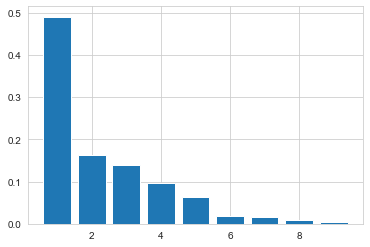

In [27]:
# Plot the variance of the data
plt.bar(range(1, len(scaled_df_pca.explained_variance_ratio_)+1), scaled_df_pca.explained_variance_ratio_)
plt.show()


### Observations
It seems 95% of variance is explained by 4 Principal Components, so we can ignore the rest

### Make The Scree Plot

In [28]:
# Get the cummulative sum
var_cumu = np.cumsum(pca.explained_variance_ratio_)

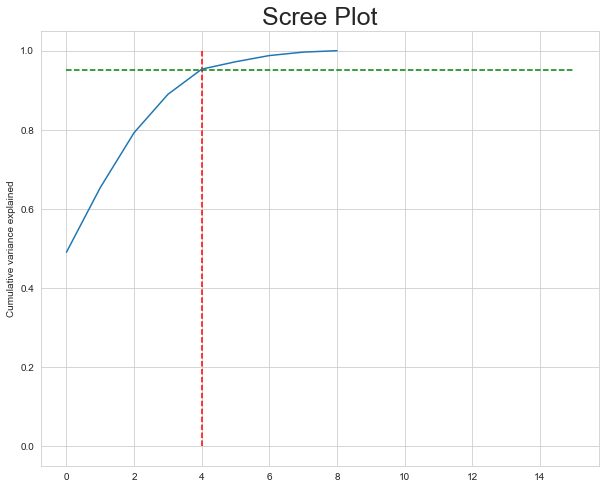

In [29]:
# Plot the data 
fig = plt.figure(figsize=[10,8])
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=15, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.title('Scree Plot', fontsize = 25)
plt.ylabel("Cumulative variance explained")
plt.show()

### Observations
As we can see, almost 95% of variance is eplained by 4 Principal Components 

### Perform PCA with 4 columns

In [30]:
# This time, we will use incremental PCA to save some extra processing

# Create an instance of the PCA
pca2 = IncrementalPCA(n_components = 4)

In [31]:
scaled_df_pca2 = pca2.fit_transform(scaled_df)

In [32]:
# Verify the shape of the new dataframe
scaled_df_pca2.shape

(167, 4)

In [33]:
# Convert the series into a Dataframe 
scaled_df_pca2 = pd.DataFrame(scaled_df_pca2)

In [34]:
# Get an overveiw of the dataframe
scaled_df_pca2.head()

,0,1,2,3
0,-3.2757,-0.4273,-1.0552,0.9062
1,0.4840,-0.1612,-0.2848,-1.4259
2,-0.4473,-0.4244,1.8326,-0.6228
3,-3.3591,1.2596,1.9806,1.7502
4,1.2441,0.6977,-0.2697,-0.7712


### Create a correlation Matrix

In [35]:
# Create the matrix using Numpy function corrcoef
corrmat = np.corrcoef(scaled_df_pca2.transpose())

In [36]:
# Verify the shape of the Matrix
corrmat.shape

(4, 4)

### Plot the Heatmap to check the correlation

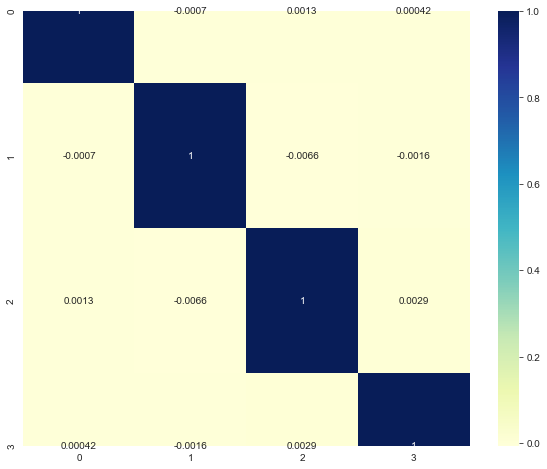

In [37]:
plt.figure(figsize = (10, 8))
sns.heatmap(corrmat, annot = True, cmap = 'YlGnBu')
plt.show()

## Observations

1. We can see that all the Principal Components are uncorrelated
2. All the Principal components have almost zero correlation

# K-Means Clustering

In [38]:
# K-Means with 4 variables
kmeans = KMeans(n_clusters=4, max_iter=50)

# Fit the scaled df
kmeans.fit(scaled_df_pca2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [39]:
# Check the labels
kmeans.labels_

array([2, 3, 0, 2, 3, 0, 0, 1, 1, 0, 1, 1, 0, 3, 3, 1, 3, 2, 3, 0, 3, 2,
       0, 1, 3, 2, 2, 3, 2, 1, 3, 2, 2, 0, 0, 0, 2, 2, 2, 3, 2, 3, 1, 3,
       1, 0, 0, 0, 3, 2, 2, 3, 3, 1, 1, 0, 2, 3, 1, 2, 1, 3, 0, 2, 2, 3,
       2, 3, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 3, 0, 2, 2, 1, 3, 2, 3, 3, 2,
       2, 0, 3, 1, 3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 0, 3, 3, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 3, 3, 0, 0, 3, 1, 1, 3, 0, 2, 3, 0, 2, 3, 3,
       2, 1, 3, 1, 3, 2, 1, 1, 0, 3, 2, 3, 1, 1, 2, 2, 3, 2, 2, 3, 3, 0,
       3, 2, 3, 1, 1, 1, 0, 0, 3, 0, 3, 2, 2])

In [76]:
# Check the silhouette score
silhouette_avg = silhouette_score(scaled_df_pca2, kmeans.labels_)
print("For n_clusters={0}, the silhouette score is {1}".format(4, silhouette_avg))

For n_clusters=4, the silhouette score is 0.4128960738047698


In [41]:
# Assign the Labels
cluster_id = kmeans.labels_

In [42]:
# Verify
cluster_id

array([2, 3, 0, 2, 3, 0, 0, 1, 1, 0, 1, 1, 0, 3, 3, 1, 3, 2, 3, 0, 3, 2,
       0, 1, 3, 2, 2, 3, 2, 1, 3, 2, 2, 0, 0, 0, 2, 2, 2, 3, 2, 3, 1, 3,
       1, 0, 0, 0, 3, 2, 2, 3, 3, 1, 1, 0, 2, 3, 1, 2, 1, 3, 0, 2, 2, 3,
       2, 3, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 3, 0, 2, 2, 1, 3, 2, 3, 3, 2,
       2, 0, 3, 1, 3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 0, 3, 3, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 3, 3, 0, 0, 3, 1, 1, 3, 0, 2, 3, 0, 2, 3, 3,
       2, 1, 3, 1, 3, 2, 1, 1, 0, 3, 2, 3, 1, 1, 2, 2, 3, 2, 2, 3, 3, 0,
       3, 2, 3, 1, 1, 1, 0, 0, 3, 0, 3, 2, 2])

# Hierarchical Clustering

### Single Linkage

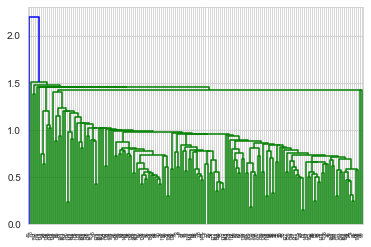

In [43]:
# single linkage
mergings = linkage(scaled_df_pca2, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [44]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [67]:
print("Hopkins Score is {0}".format(hopkins(scaled_df_pca2)))

Hopkins Score is 0.839734572937609


### Complete Linkage

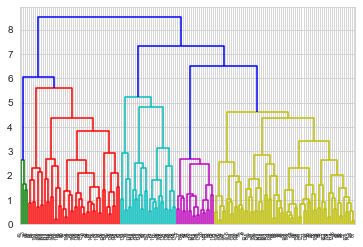

In [46]:
# complete linkage
mergings = linkage(scaled_df_pca2, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

# Observations

Looking at the dendrogram, it seems 5 clusters would be sufficient

In [47]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, )
cluster_labels


array([0, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 4, 1, 1, 1, 4, 1, 0, 1, 1, 1, 0,
       1, 4, 1, 0, 0, 1, 0, 3, 1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 4, 4,
       3, 1, 1, 1, 1, 2, 0, 4, 1, 3, 3, 0, 0, 1, 3, 0, 3, 1, 1, 0, 0, 1,
       0, 4, 3, 1, 1, 1, 0, 4, 3, 3, 1, 3, 1, 1, 0, 0, 4, 1, 0, 1, 1, 0,
       0, 4, 4, 4, 1, 0, 0, 4, 4, 0, 4, 2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       4, 3, 0, 0, 3, 4, 0, 4, 1, 1, 1, 1, 3, 4, 1, 1, 0, 1, 4, 0, 1, 4,
       0, 4, 4, 4, 0, 0, 4, 3, 1, 1, 0, 1, 3, 4, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 4, 3, 3, 1, 1, 1, 1, 4, 0, 0])

In [48]:
# Rename the columns and add cluster_id and cluster_labels columns
scaled_df_pca2.columns = ['PC1', 'PC2', 'PC3', 'PC4']
scaled_df_pca2['cluster_id'] = cluster_id ## obtained by K-Means
scaled_df_pca2['cluster_label'] = cluster_labels ## obtained by Heirarchical clustering


In [49]:
# Verify the dataframe
scaled_df_pca2.head()

,PC1,PC2,PC3,PC4,cluster_id,cluster_label
0,-3.2757,-0.4273,-1.0552,0.9062,2,0
1,0.4840,-0.1612,-0.2848,-1.4259,3,1
2,-0.4473,-0.4244,1.8326,-0.6228,0,1
3,-3.3591,1.2596,1.9806,1.7502,2,2
4,1.2441,0.6977,-0.2697,-0.7712,3,1


In [50]:
# Now, add(merge) the country column into the dataframe
df_cluster = pd.concat([df_orig['country'], scaled_df_pca2], axis=1, ignore_index = False)
df_cluster.head()

,country,PC1,PC2,PC3,PC4,cluster_id,cluster_label
0,Afghanistan,-3.2757,-0.4273,-1.0552,0.9062,2,0
1,Albania,0.4840,-0.1612,-0.2848,-1.4259,3,1
2,Algeria,-0.4473,-0.4244,1.8326,-0.6228,0,1
3,Angola,-3.3591,1.2596,1.9806,1.7502,2,2
4,Antigua and Barbuda,1.2441,0.6977,-0.2697,-0.7712,3,1


# Visualise The Clusters

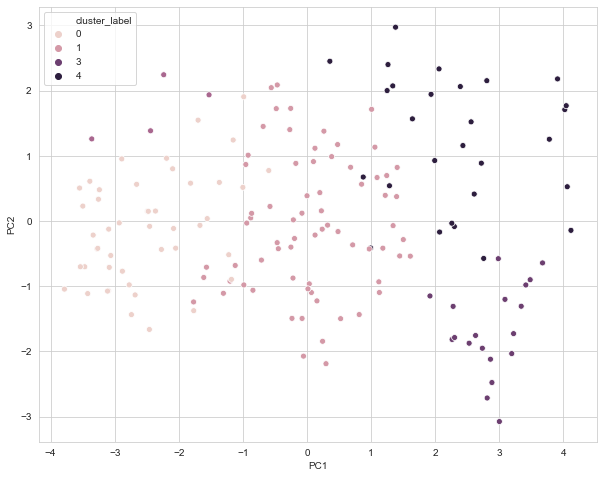

In [51]:
plt.figure(figsize = (10,8))
sns.scatterplot(data = df_cluster, x = 'PC1', y = 'PC2', hue = 'cluster_label')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [52]:
df_cluster_final = df_cluster[['country', 'cluster_label']].merge(df_orig, on = 'country', how = 'inner')

In [53]:
df_cluster_final.head()

,country,cluster_label,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,0,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,1,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,1,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,2,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,1,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


# Analyse The Clusters For Original Variables
- Analyse the clusters based on `gdpp`, `child_mort` and `income`.
- We can group the coutries, based on these three Features and analyse the clusters

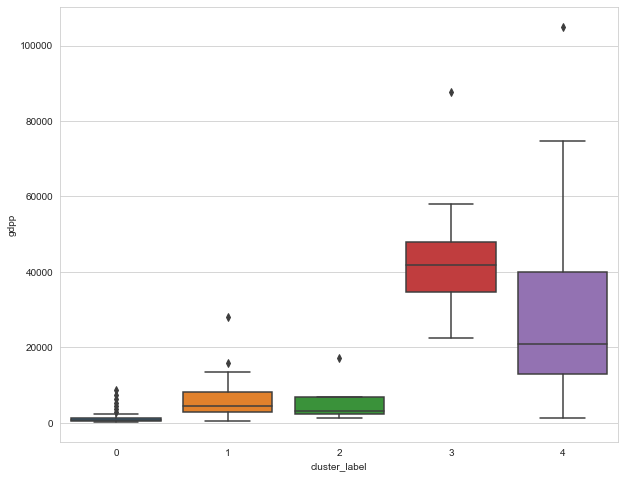

In [54]:
# Plot the data for gdpp
plt.figure(figsize = (10,8))
sns.boxplot(x = 'cluster_label', y = 'gdpp', data = df_cluster_final)
plt.show()

# Observations

- Countries that belong to Cluster_Label '0' have the least GDPP.
- These countries can be considered as backward countries.
- Countries taht belong to Clusger_Label '4' have the highest GDPP.

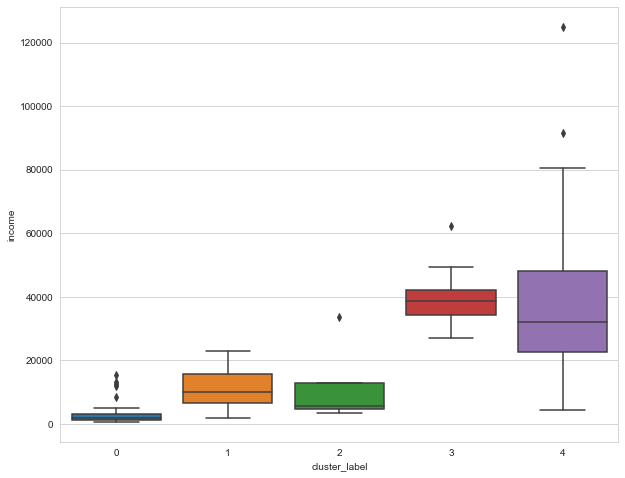

In [55]:
# Plot the data for Income
plt.figure(figsize = (10,8))
sns.boxplot(x = 'cluster_label', y = 'income', data = df_cluster_final)
plt.show()

# Observations

- Countries that belong to Cluster_Label '0' have the least net income. Thus, these countries can be considered as backward.
- Countries that belong to Cluster_Label '4' have the highest net income and are very well developed countries.

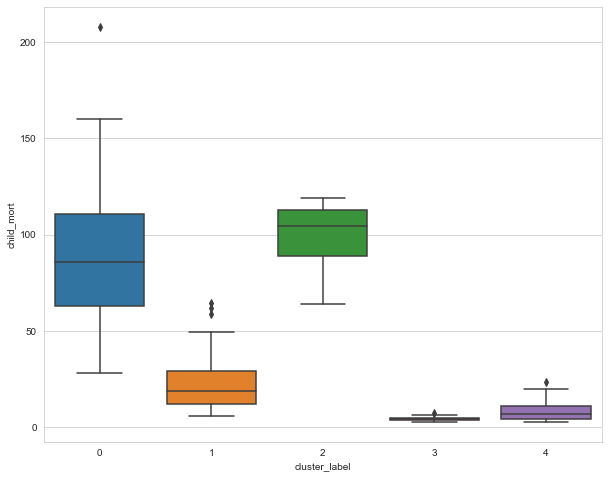

In [56]:
# Plot the data for Child Mortality
plt.figure(figsize = (10,8))
sns.boxplot(x = 'cluster_label', y = 'child_mort', data = df_cluster_final)
plt.show()

In [57]:
# List of countries that are in dire need of aid
df_cluster_final[df_cluster_final['cluster_label'] == 0].count()

for country in df_cluster_final[df_cluster_final['cluster_label'] == 0].country.values:
    print(country)

Afghanistan
Benin
Botswana
Burkina Faso
Burundi
Cameroon
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Cote d'Ivoire
Eritrea
Gabon
Gambia
Ghana
Guinea
Guinea-Bissau
Haiti
Iraq
Kenya
Kiribati
Lao
Lesotho
Liberia
Madagascar
Malawi
Mali
Micronesia, Fed. Sts.
Mozambique
Namibia
Niger
Nigeria
Pakistan
Rwanda
Senegal
Sierra Leone
Solomon Islands
South Africa
Sudan
Tajikistan
Tanzania
Timor-Leste
Togo
Uganda
Yemen
Zambia


# Observations
- It is evident that the countries belong to Cluster_Label '0' have the highest child mortality rate.
- Countries in Cluster_Label '3' have the least child mortality rate.

# Recommendations

As per the analysis and evidence from the graphs, the countries that belong to Cluster_Label '0' have:
- Low GDPP
- Low Net Income
- High Child Mortality

Therefore, these countries are backward countries and are in dire need of aid. NGOs should focus more on these countries:
The list of the countries:

- Afghanistan
- Benin
- Botswana
- Burkina Faso
- Burundi
- Cameroon
- Central African Republic
- Chad
- Comoros
- Congo, Dem. Rep.
- Cote d'Ivoire
- Eritrea
- Gambia
- Guinea-Bissau
- Haiti
- Iraq
- Kenya
- Kiribati
- Lao
- Lesotho
- Liberia
- Madagascar
- Malawi
- Mali
- Micronesia, Fed. Sts.
- Mozambique
- Namibia
- Niger
- Pakistan
- Rwanda
- Senegal
- Sierra Leone
- Solomon Islands
- South Africa
- Tanzania
- Timor-Leste
- Togo
- Uganda
- Zambia